<center><img src="images/logo.png" alt="drawing" width="400" style="background-color:white; padding:1em;" /></center> <br/>

# ML through Application
## Module 2, Lab 4: Using Logistic Regression

In this notebook, you will build a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model to predict the Outcome Type feature of the dataset. You will also look at how probability threshold calibration can help to improve a classifier's performance.
Probability threshold calibration is a way to calibrate the model working on the output from the logistic regression model for binary classification. For example, if the model needs to predict class 1, you can put a threshold to consider that the the output belongs to class 1 only if the probability is greater than 80%. Otherwise, it belongs to class 0.

You will learn how to do the following:

- Do basic data processing.
- Explain how and why you create training, testing, and validation datasets.
- Use a pipeline and ColumnTransformers to process data.
- Train a classifier.
- Test the performance of a classifier.
- Identify ways to improve a classifier by using probability threshold calibration.

----

__Austin Animal Center Dataset__

In this lab, you will work with historical pet adoption data in the [Austin Animal Center Shelter Intakes and Outcomes dataset](https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes?resource=download). The target field of the dataset (**Outcome Type**) is the outcome of adoption: 1 for adopted and 0 for not adopted. Multiple features are used in the dataset.

Dataset schema:
- __Pet ID:__ Unique ID of the pet
- __Outcome Type:__ State of pet at the time of recording the outcome (0 = not placed, 1 = placed). This is the field to predict.
- __Sex upon Outcome:__ Sex of pet at outcome
- __Name:__ Name of pet 
- __Found Location:__ Found location of pet before it entered the shelter
- __Intake Type:__ Circumstances that brought the pet to the shelter
- __Intake Condition:__ Health condition of the pet when it entered the shelter
- __Pet Type:__ Type of pet
- __Sex upon Intake:__ Sex of pet when it entered the shelter
- __Breed:__ Breed of pet 
- __Color:__ Color of pet 
- __Age upon Intake Days:__ Age (days) of pet when it entered the shelter
- __Age upon Outcome Days:__ Age (days) of pet at outcome

----

You will be presented with two kinds of exercises throughout the notebook: activities and challenges. <br/>

| <img style="float: center;" src="images/activity.png" alt="Activity" width="125"/>| <img style="float: center;" src="images/challenge.png" alt="Challenge" width="125"/>|
| --- | --- |
|<p style="text-align:center;">No coding is needed for an activity. You try to understand a concept, <br/>answer questions, or run a code cell.</p> |<p style="text-align:center;">Challenges are where you can practice your coding skills.</p>

## Index

- [Data processing](#Data-processing)
- [Train a classifier](#Train-a-classifier)
- [Test the classifier](#Test-the-classifier)
- [Improvement ideas: Probability threshold calibration](#Improvement-ideas:-Probability-threshold-calibration)

---
## Data processing

To get started, you will process the dataset the same way that you did in the previous labs. Run all the cells in this section before you move to the section where you train the model.

One of the most important steps is to clean the data. You should do this _before_ you split the data into training, testing, and validation datasets to be more efficient with your coding.

In [1]:
%%capture
# installing libraries
!pip install -U -q -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.impute import SimpleImputer

In [3]:
df = pd.read_csv("data/review_dataset.csv")

print("The shape of the dataset is:", df.shape)

The shape of the dataset is: (95485, 13)


To remember what the data looks like, print the names of the features.

In [4]:
print(df.columns)

Index(['Pet ID', 'Outcome Type', 'Sex upon Outcome', 'Name', 'Found Location',
       'Intake Type', 'Intake Condition', 'Pet Type', 'Sex upon Intake',
       'Breed', 'Color', 'Age upon Intake Days', 'Age upon Outcome Days'],
      dtype='object')


<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="images/challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">In the following code cell, create four lists that contain the names of the numerical, categorical, text, and all features, in addition to a variable for the target (label).</p><br>
    <p style=" text-align: center; margin: auto;">Use the following names for the lists: <code>numerical_features</code>, <code>categorical_features</code>, <code>text_features</code>, <code>model_features</code>, and <code>model_target</code>.</p>
    <br>
    <p style=" text-align: center; margin: auto;"> Note: Omit the Pet ID and Name features from the lists because they aren't relevant to the outcome.</p><br>
</div>



In [5]:
############### CODE HERE ###############
numerical_features = ["Age upon Intake Days", "Age upon Outcome Days"]

categorical_features = [
    "Sex upon Outcome",
    "Intake Type",
    "Intake Condition",
    "Pet Type",
    "Sex upon Intake",
]

text_features = ["Found Location", "Breed", "Color"]

model_features = numerical_features + categorical_features + text_features

model_target = "Outcome Type"
############## END OF CODE ##############

### Clean numerical features

As you did in the previous lab, examine the numerical features. Remember that the `value_counts()` function can provide a view of the numerical features by placing feature values in respective bins. The function can also be used to plot a graph.

(-9.126, 912.5]     74835
(912.5, 1825.0]     10647
(1825.0, 2737.5]     3471
(2737.5, 3650.0]     3998
(3650.0, 4562.5]     1234
(4562.5, 5475.0]     1031
(5475.0, 6387.5]      183
(6387.5, 7300.0]       79
(7300.0, 8212.5]        5
(8212.5, 9125.0]        2
Name: count, dtype: int64


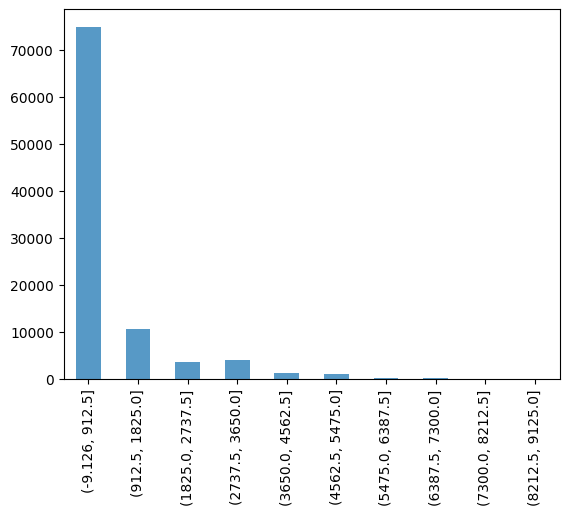

(-9.126, 912.5]     74642
(912.5, 1825.0]     10699
(1825.0, 2737.5]     3465
(2737.5, 3650.0]     4080
(3650.0, 4562.5]     1263
(4562.5, 5475.0]     1061
(5475.0, 6387.5]      187
(6387.5, 7300.0]       81
(7300.0, 8212.5]        5
(8212.5, 9125.0]        2
Name: count, dtype: int64


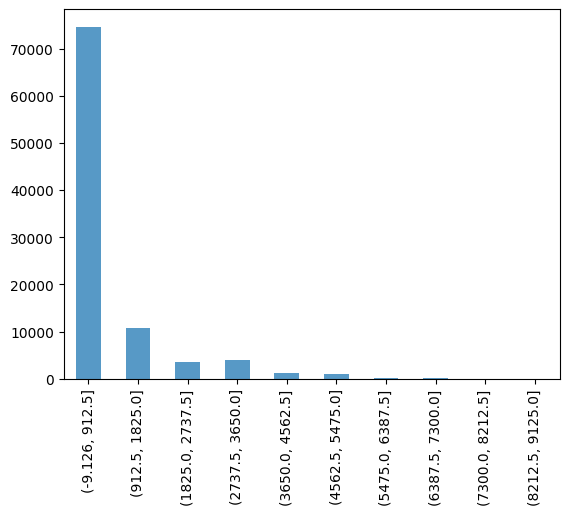

In [6]:
for c in numerical_features:
    print(df[c].value_counts(bins=10, sort=False))
    df[c].value_counts(bins=10, sort=False).plot(kind="bar", alpha=0.75, rot=90)
    plt.show()

If any outliers are identified as likely wrong values, dropping them could improve the numerical values histograms and overall model performance.

In this lab, you will remove any values in the upper 10 percent for the feature and then plot the features.

In [7]:
for c in numerical_features:
    # Drop values beyond 90% of max()
    dropIndexes = df[df[c] > df[c].max() * 9 / 10].index
    df.drop(dropIndexes, inplace=True)

(-6.936, 693.5]     61425
(693.5, 1387.0]     18400
(1387.0, 2080.5]     5657
(2080.5, 2774.0]     3471
(2774.0, 3467.5]     2557
(3467.5, 4161.0]     1962
(4161.0, 4854.5]     1148
(4854.5, 5548.0]      596
(5548.0, 6241.5]      183
(6241.5, 6935.0]       63
Name: count, dtype: int64


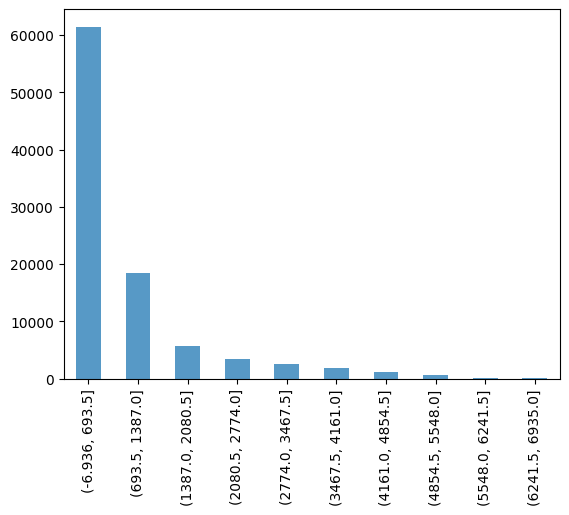

(-6.936, 693.5]     61208
(693.5, 1387.0]     18490
(1387.0, 2080.5]     5643
(2080.5, 2774.0]     3465
(2774.0, 3467.5]     2600
(3467.5, 4161.0]     2004
(4161.0, 4854.5]     1196
(4854.5, 5548.0]      604
(5548.0, 6241.5]      187
(6241.5, 6935.0]       65
Name: count, dtype: int64


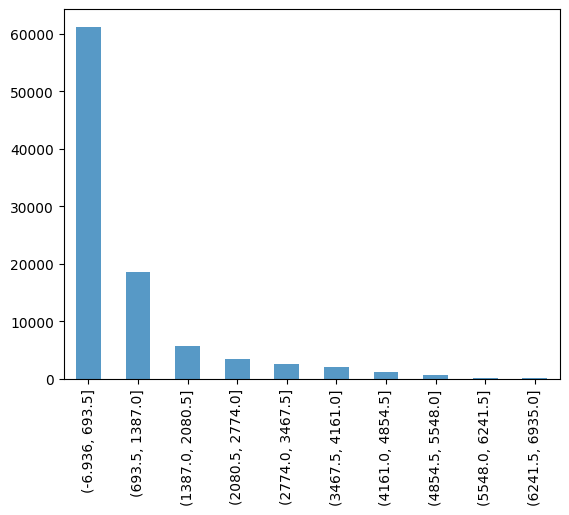

In [8]:
for c in numerical_features:
    print(df[c].value_counts(bins=10, sort=False))
    df[c].value_counts(bins=10, sort=False).plot(kind="bar", alpha=0.75, rot=90)
    plt.show()

### Clean text features

As you did in the previous lab, examine the text features. You can re-use the helper function from the previous notebook to process the data.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="images/challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">In the following code cell, write the <code>preProcessText()</code>, <code>lexiconProcess()</code>, and <code>cleanSentence()</code> helper functions.</p><br>
    <p style=" text-align: center; margin: auto;">You might need to refer to the notebook from the previous lab.</p>
    <br>
</div>



In [9]:
# Prepare cleaning functions
import re, string
import nltk
from nltk.stem import SnowballStemmer

stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and", "in"]

stemmer = SnowballStemmer("english")

############### CODE HERE ###############
# Define a function to remove white space, HTML, punctuation, and numbers
def preProcessText(text):
    # Lowercase text, and strip leading and trailing white space
    text = text.lower().strip()

    # Remove HTML tags
    text = re.compile("<.*?>").sub("", text)

    # Remove punctuation
    text = re.compile("[%s]" % re.escape(string.punctuation)).sub(" ", text)

    # Remove extra white space
    text = re.sub("\s+", " ", text)

    # Remove numbers
    text = re.sub(r"[0-9]", "", text)

    return text


# Define a function to remove stop words and stem the words
def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)

    return text


# Define a function to clean a sentence
def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)
############## END OF CODE ##############

__Warning:__ The text cleaning process can take a long time to complete, depending on the size of the text data.

In [10]:
# Clean the text features
for c in text_features:
    print("Text cleaning: ", c)
    df[c] = [cleanSentence(item, stop_words, stemmer) for item in df[c].values]

Text cleaning:  Found Location
Text cleaning:  Breed
Text cleaning:  Color


---
### Create training, test, and validation datasets

Now that the data has been cleaned, you need to split the full dataset into training and test subsets by using sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. This function allows you to specify the following:

- The proportion of the dataset to include in the test split, as a number in the range 0.0–1.0 with a default of 0.25.
- An integer that controls the shuffling that is applied to the data before the split. Passing an integer allows for reproducible output across multiple function calls.

To help reduce sampling bias, the original dataset is shuffled before the split. After the initial split, the training data is further split into training and validation subsets.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="images/challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">In the following code cell, split the original dataset into training and test subsets by using sklearn's <code>train_test_split()</code> function.</p><br>
    <p style=" text-align: center; margin: auto;">From the original DataFrame, create DataFrames that are named <code>train_data</code> and <code>test_data</code>.</p>
    <p style=" text-align: center; margin: auto;">From the <code>train_data</code> DataFrame, create DataFrames that are named <code>train_data</code> and <code>val_data</code>.</p>
    <br>
</div>



In [11]:
from sklearn.model_selection import train_test_split

############### CODE HERE ###############
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
############## END OF CODE ##############

# Print the shapes of the training, validation, and test datasets
print(
    "Train - Test - Validation dataset shapes: ",
    train_data.shape,
    val_data.shape,
    test_data.shape,
)

Train - Test - Validation dataset shapes:  (61095, 13) (15274, 13) (19093, 13)


---
### Process the data with a pipeline and ColumnTransformer

In a typical ML workflow, you need to apply data transformations, such as imputation and scaling, at least twice: first on the training dataset by using `.fit()` and `.transform()` when preparing the data to train the model, and then by using `.transform()` on any new data that you want to predict on (validation or test). Sklearn's [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) is a tool that simplifies this process by enforcing the implementation and order of data processing steps, being important for reproducibility. In other words, all the data is transformed the same way each time that you process any part of it.

In this section, you will build separate pipelines to handle the numerical, categorical, and text features. Then, you will combine them into a composite pipeline along with an estimator. To do this, you will use a [LogisticRegression classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

You will need multiple pipelines to ensure that all the data is handled correctly:

* __Numerical features pipeline:__ Impute missing values with the mean by using sklearn's SimpleImputer, followed by a MinMaxScaler. If different processing is desired for different numerical features, different pipelines should be built as described for the text features pipeline. See the `numerical_processor` in the following code cell.

* __Categoricals pipeline:__ Impute with a placeholder value (this won't have an effect because you already encoded the 'nan' values), and encode with sklearn's OneHotEncoder. If computing memory is an issue, it is a good idea to check the number of unique values for the categoricals to get an estimate of how many dummy features one-hot encoding will create. Note the `handle_unknown` parameter, which tells the encoder to ignore (rather than throw an error for) any unique value that might show in the validation or test set that was not present in the initial training set. See the `categorical_processor` in the following code cell.

* __Text features pipeline:__ With memory usage in mind, build three more pipelines, one for each of the text features. Current sklearn implementation requires a separate transformer for each text feature (unlike the numericals and categoricals).

Finally, the selective preparations of the dataset features are then put together into a collective ColumnTransformer, which is used in a pipeline along with an estimator. This ensures that the transforms are performed automatically in all situations. This includes on the raw data when fitting the model, when making predictions, when evaluating the model on a validation dataset through cross-validation, or when making predictions on a test dataset in the future.

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline(
    [
        ("num_imputer", SimpleImputer(strategy="mean")),
        (
            "num_scaler",
            MinMaxScaler(),
        ),  # Shown in case it is needed. Not a must with decision trees.
    ]
)

# Preprocess the categorical features
categorical_processor = Pipeline(
    [
        (
            "cat_imputer",
            SimpleImputer(strategy="constant", fill_value="missing"),
        ),  # Shown in case it is needed. No effect because you already imputed with 'nan' strings.
        (
            "cat_encoder",
            OneHotEncoder(handle_unknown="ignore"),
        ),  # handle_unknown tells it to ignore (rather than throw an error for) any value that was not present in the initial training set.
    ]
)

# Preprocess first text feature
text_processor_0 = Pipeline(
    [("text_vectorizer_0", CountVectorizer(binary=True, max_features=50))]
)

# Preprocess second text feature
text_processor_1 = Pipeline(
    [("text_vectorizer_1", CountVectorizer(binary=True, max_features=50))]
)

# Preprocess third text feature
text_processor_2 = Pipeline(
    [("text_vectorizer_2", CountVectorizer(binary=True, max_features=50))]
)

# Combine all data preprocessors (add more if you choose to define more)
# For each processor/step, specify: a name, the actual process, and the features to be processed.
data_processor = ColumnTransformer(
    [
        ("numerical_processing", numerical_processor, numerical_features),
        ("categorical_processing", categorical_processor, categorical_features),
        ("text_processing_0", text_processor_0, text_features[0]),
        ("text_processing_1", text_processor_1, text_features[1]),
        ("text_processing_2", text_processor_2, text_features[2]),
    ]
)

# Visualize the data processing pipeline
from sklearn import set_config

set_config(display="diagram")
data_processor

ColumnTransformer(transformers=[('numerical_processing',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  MinMaxScaler())]),
                                 ['Age upon Intake Days',
                                  'Age upon Outcome Days']),
                                ('categorical_processing',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))])...
                                ('text_processing_0',
                                 Pipeline(steps=[('text_vectorizer_0',
                                                  CountVectorizer(binary=True,
                                                                  max_features=50))]),
                                 'Found Location'),
                                ('text_processing_1',
                                 Pipeline(steps=[('text_vectorizer_1',
                                                  CountVectorizer(binary=True,
                                                                  max_features=50))]),
                                 'Breed'),
                                ('text_processing_2',
                                 Pipeline(steps=[('text_vectorizer_2',
                                                  CountVectorizer(binary=True,
                                                                  max_features=50))]),
                                 'Color')])

---
## Train a classifier

To train a logistic regression model, you will use sklearn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). 


<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>It's time to check your knowledge!</i></h3>
    <br>
    <p style=" text-align: center; margin: auto;">To load the question, run the following cell.</p>
    <br>
</div>

In [13]:
# Run this cell for a knowledge check question
from MLUMLA_EN_M2_Lab4_quiz_questions import *

question_1

### Logistic regression

Update the pipeline that includes the desired data transformers to _include_ a logistic regression estimator.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

### PIPELINE ###
################

# Pipeline with all desired data transformers, along with an estimator
# Later, you can set/reach the parameters by using the names issued - for hyperparameter tuning, for example
pipeline = Pipeline(
    [
        ("data_processing", data_processor),
        (
            "lg",
            LogisticRegression(
                solver="liblinear", penalty="l1", C=0.001, class_weight={0: 1, 1: 20}
            ),
        ),
    ]
)

# Visualize the pipeline
# This will be helpful especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config

set_config(display="diagram")
pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age upon Intake Days',
                                                   'Age upon Outcome Days']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHot...
                                                                                   max_features=50))]),
                                                  'Found Location'),
                                                 ('text_processing_1',
                                                  Pipeline(steps=[('text_vectorizer_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'Breed'),
                                                 ('text_processing_2',
                                                  Pipeline(steps=[('text_vectorizer_2',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'Color')])),
                ('lg',
                 LogisticRegression(C=0.001, class_weight={0: 1, 1: 20},
                                    penalty='l1', solver='liblinear'))])

### Model training

Finally, train the classifier with `.fit()` on the training dataset. 

In [15]:
# Get training data to train the classifier
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the classifier to the training data
# Training data going through the pipeline is imputed (with means from the training data),
#   scaled (with the min/max from the training data),
#   and finally used to fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age upon Intake Days',
                                                   'Age upon Outcome Days']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHot...
                                                                                   max_features=50))]),
                                                  'Found Location'),
                                                 ('text_processing_1',
                                                  Pipeline(steps=[('text_vectorizer_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'Breed'),
                                                 ('text_processing_2',
                                                  Pipeline(steps=[('text_vectorizer_2',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'Color')])),
                ('lg',
                 LogisticRegression(C=0.001, class_weight={0: 1, 1: 20},
                                    penalty='l1', solver='liblinear'))])

---
## Test the classifier


<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="images/challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Now that you have a trained classifier, you can evaluate the performance on the test dataset.</p>
    <p style=" text-align: center; margin: auto;">In the following code cell, use <code>.predict()</code> on the <code>pipeline</code> to do this.</p>
    <br>
</div>



In [16]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get validation data to validate the classifier
X_test = test_data[model_features]
y_test = test_data[model_target]

# Use the fitted model to make predictions on the test dataset
# Testing data going through the pipeline is imputed (with means from the training data),
#   scaled (with the min/max from the training data),
#   and finally used to make predictions
############### CODE HERE ###############

test_predictions = pipeline.predict(X_test)

############## END OF CODE ##############

print("Model performance on the test set:")
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Test accuracy:", accuracy_score(y_test, test_predictions))

Model performance on the test set:
[[ 1097  7175]
 [    2 10819]]
              precision    recall  f1-score   support

         0.0       1.00      0.13      0.23      8272
         1.0       0.60      1.00      0.75     10821

    accuracy                           0.62     19093
   macro avg       0.80      0.57      0.49     19093
weighted avg       0.77      0.62      0.53     19093

Test accuracy: 0.624103074425182


<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>It's time to check your knowledge!</i></h3>
    <br>
    <p style=" text-align: center; margin: auto;">To load the question, run the following cell.</p>
    <br>
</div>

In [17]:
# Run this cell for a knowledge check question
question_2

---
## Improvement ideas: Probability threshold calibration

Other than tuning LogisticRegression hyperparameter values, another path to improve a classifier's performance is to dig deeper into how the classifier actually assigns class membership.

### Comparing binary predictions and probability predictions

You can use `classifier.predict()` to examine classifier binary predictions, although the outputs of most classifiers are real-valued, not binary. For most classifiers in sklearn, the `classifier.predict_proba()` method returns class probabilities as a 2D NumPy array of shape (n_samples, n_classes) where the classes are lexicographically ordered.

For this example, you will look at the first five predictions made, in binary format and in real-valued probability format:

In [18]:
pipeline.predict(X_test)[0:5]

array([1., 1., 1., 1., 1.])

In [19]:
pipeline.predict_proba(X_test)[0:5]

array([[0.03302149, 0.96697851],
       [0.37922494, 0.62077506],
       [0.02043505, 0.97956495],
       [0.00742047, 0.99257953],
       [0.02043505, 0.97956495]])

How are the predicted probabilities used to decide class membership? On each row of `predict_proba` output, the probability values sum to 1. The array has two columns, one for each response class: column 0 is the predicted probability that each observation is a member of class 0, and column 1 is the predicted probability that each observation is a member of class 1. From the predicted probabilities, choose the class with the highest probability.

The key here is that a threshold of 0.5 is used by default (for binary problems) to convert predicted probabilities into class predictions: class 0, if predicted probability is less than 0.5, and class 1, if predicted probability is greater than 0.5.

Can you improve classifier performance by changing the classification threshold? Adjust the classification threshold to influence the performance of the classifier.

### Threshold calibration to improve model accuracy

Calculate the accuracy by using different values for the classification threshold, and select the threshold that results in the highest accuracy.

Highest accuracy on test: 0.8262714083695595 , Threshold for the highest accuracy: 0.93


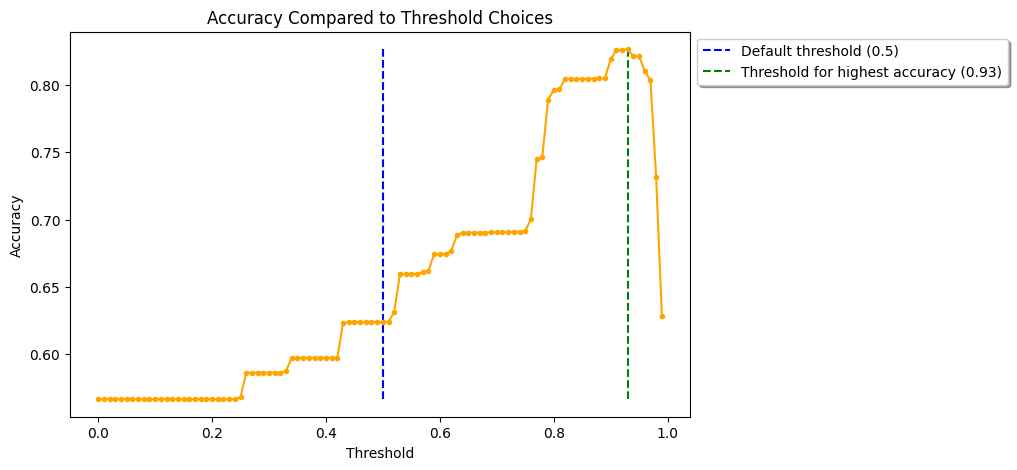

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Calculate the accuracy by using different values for the classification threshold,
# and select the threshold that results in the highest accuracy.
highest_accuracy = 0
threshold_highest_accuracy = 0

thresholds = np.arange(0, 1, 0.01)
scores = []
for t in thresholds:
    # Set threshold to 't' instead of 0.5
    y_test_other = (pipeline.predict_proba(X_test)[:, 1] >= t).astype(float)
    score = accuracy_score(y_test, y_test_other)
    scores.append(score)
    if score > highest_accuracy:
        highest_accuracy = score
        threshold_highest_accuracy = t
print(
    "Highest accuracy on test:",
    highest_accuracy,
    ", Threshold for the highest accuracy:",
    threshold_highest_accuracy,
)

# Plot the accuracy against the threshold choices
plt.rcParams["figure.figsize"] = (8, 5)
plt.plot(
    [0.5, 0.5],
    [np.min(scores), np.max(scores)],
    linestyle="--",
    color="blue",
    label="Default threshold (0.5)",
)
plt.plot(
    [threshold_highest_accuracy, threshold_highest_accuracy],
    [np.min(scores), np.max(scores)],
    linestyle="--",
    color="green",
    label="Threshold for highest accuracy ({})".format(threshold_highest_accuracy),
)
plt.plot(thresholds, scores, marker=".", color="orange")
plt.title("Accuracy Compared to Threshold Choices")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fancybox=True, shadow=True, ncol=1)
plt.show()

----
## Conclusion

This notebook showed you how to create pipelines to process your data and generate your first logistic regression model.

## Next lab

In the next lab, you will gain experience with two main types of hyperparameter tuning: grid search and randomized search.